In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [30]:
# Cargar el dataset
data = pd.read_csv('final_dataset.csv')

# Eliminar primeras 3 jornadas para estabilidad estadística
data = data[data.MW > 3]

# Convertir fechas
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Drop columnas irrelevantes para modelado directo
data.drop(['Unnamed: 0', 'HomeTeam', 'AwayTeam', 'MW',
           'HTFormPtsStr', 'ATFormPtsStr', 'HomeTeamLP', 'AwayTeamLP',
           'HTWinStreak3', 'ATWinStreak3', 'HTWinStreak5', 'ATWinStreak5',
           'HTLossStreak3', 'ATLossStreak3', 'HTLossStreak5', 'ATLossStreak5',
           'HM4', 'HM5', 'AM4', 'AM5'], axis=1, inplace=True)

data.head()

,Date,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,...,AM1,AM2,AM3,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
30,2000-09-05,6,0,H,5,2,3,1,1.25,1.00,...,D,W,L,5,4,0.50,0.25,0.25,0.25,-16.0
31,2000-09-05,1,1,NH,3,4,5,7,0.75,0.25,...,D,L,L,3,1,-0.50,-0.75,0.50,0.50,-2.0
32,2000-09-05,3,2,H,4,5,4,4,1.00,1.00,...,D,W,L,4,4,0.00,0.25,0.00,0.00,-3.0
33,2000-09-06,1,1,NH,7,6,8,7,0.75,0.50,...,D,L,D,3,2,-0.25,-0.25,0.25,0.25,3.0
34,2000-09-06,2,2,NH,5,7,5,4,1.00,1.50,...,W,W,L,4,6,0.00,0.75,-0.50,-0.50,3.0


In [16]:
print(f"Número total de partidos: {data.shape[0]}")
print(f"Número de características: {data.shape[1] - 1}")  # menos FTR
print(f"Victorias del local: {len(data[data.FTR == 'H'])}")
print(f"Tasa de victoria local: {len(data[data.FTR == 'H'])/len(data)*100:.2f}%")
print("\nDistribución de resultados:\n", data['FTR'].value_counts(normalize=True))

Número total de partidos: 5600
Número de características: 21
Victorias del local: 2603
Tasa de victoria local: 46.48%

Distribución de resultados:
 FTR
NH    0.535179
H     0.464821
Name: proportion, dtype: float64


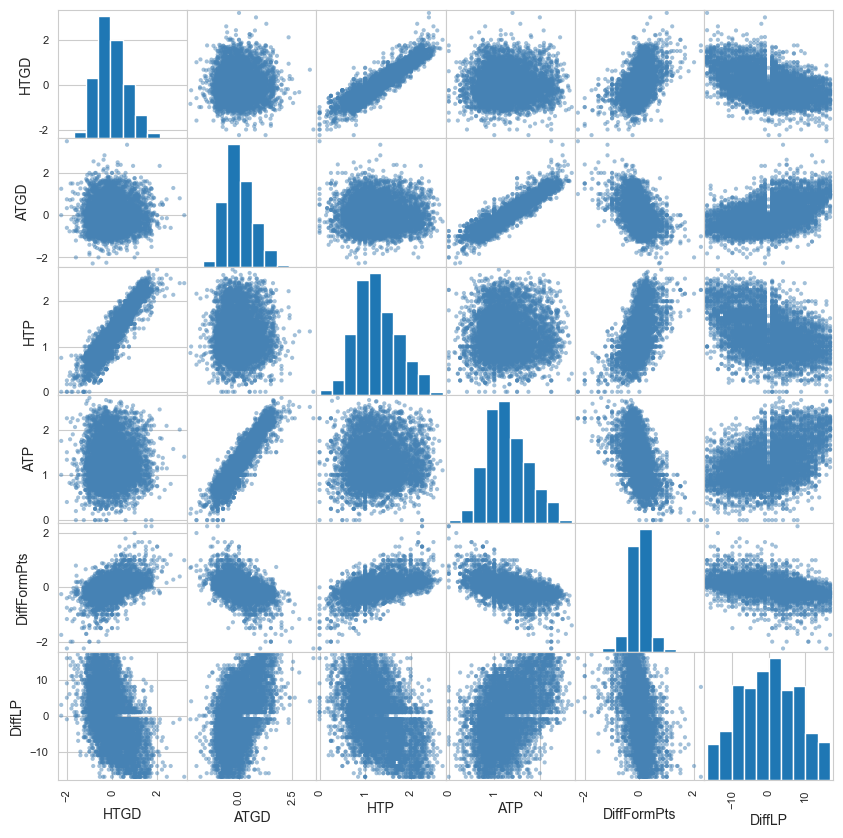

In [17]:
scatter_matrix(data[['HTGD', 'ATGD', 'HTP', 'ATP', 'DiffFormPts', 'DiffLP']],
               figsize=(10, 10), diagonal='hist', color='steelblue')
plt.show()

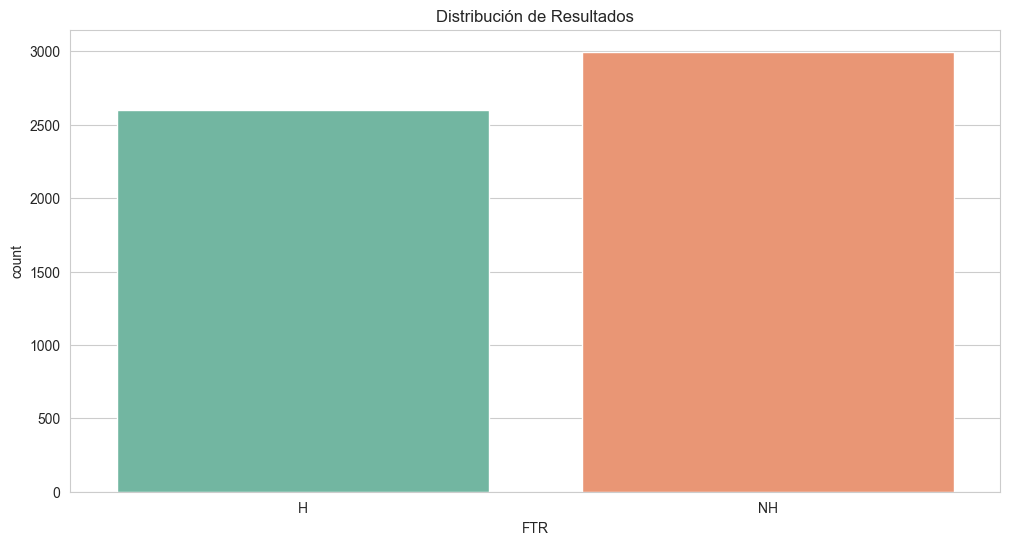

In [18]:
sns.countplot(x='FTR', data=data, palette='Set2')
plt.title('Distribución de Resultados')
plt.show()

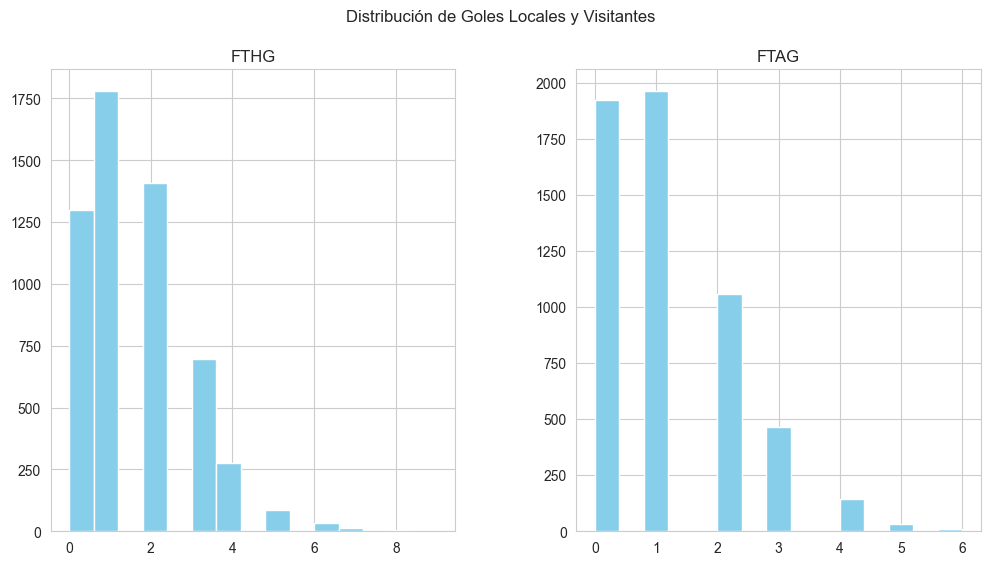

In [22]:
data[['FTHG', 'FTAG']].hist(bins=15, color=['skyblue'])
plt.suptitle('Distribución de Goles Locales y Visitantes')
plt.show()

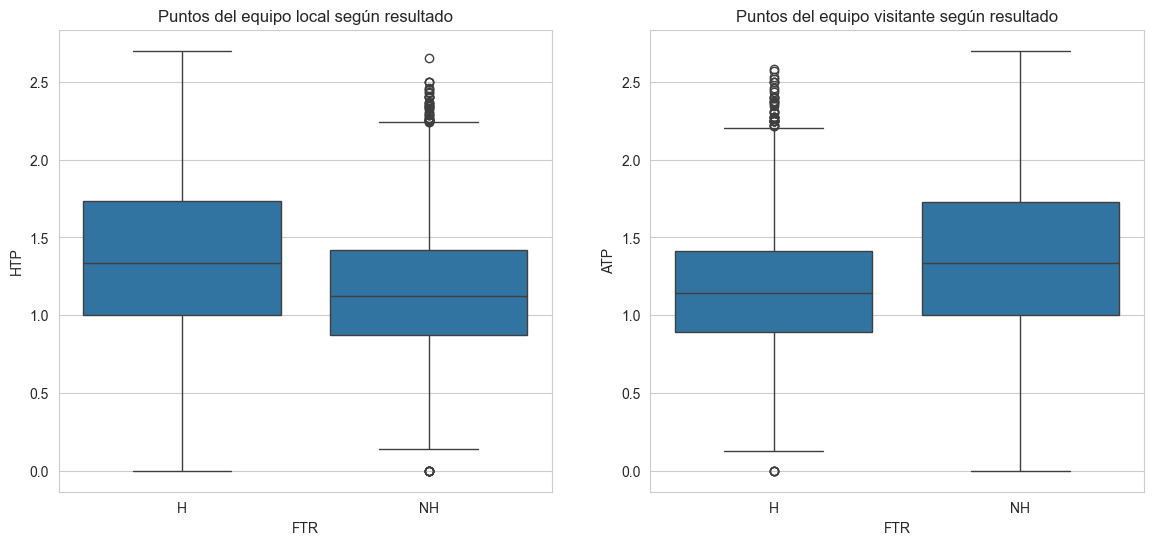

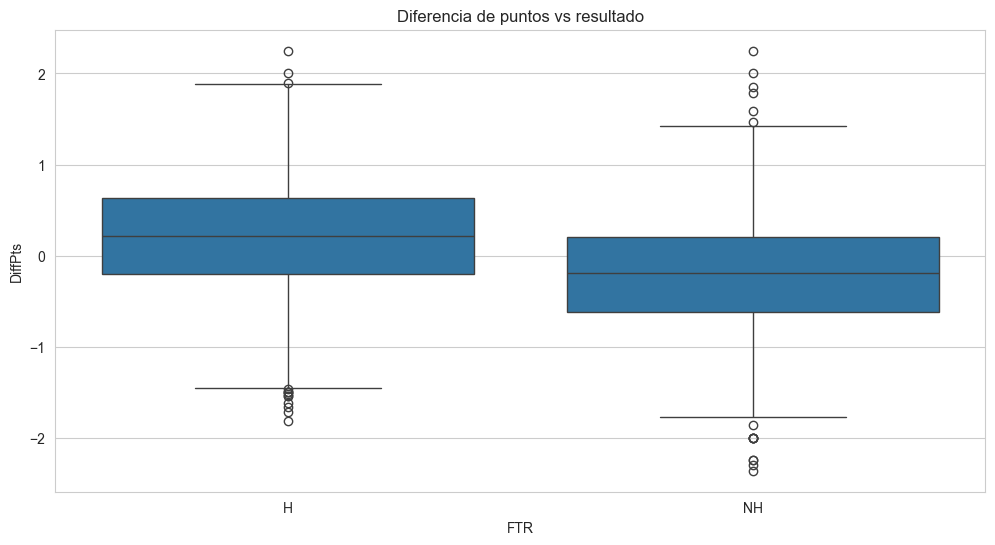

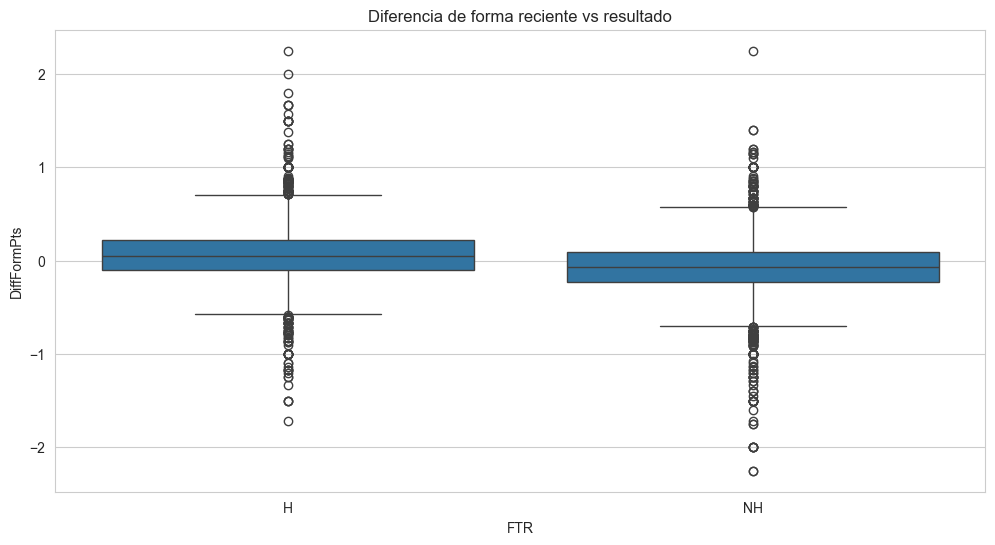

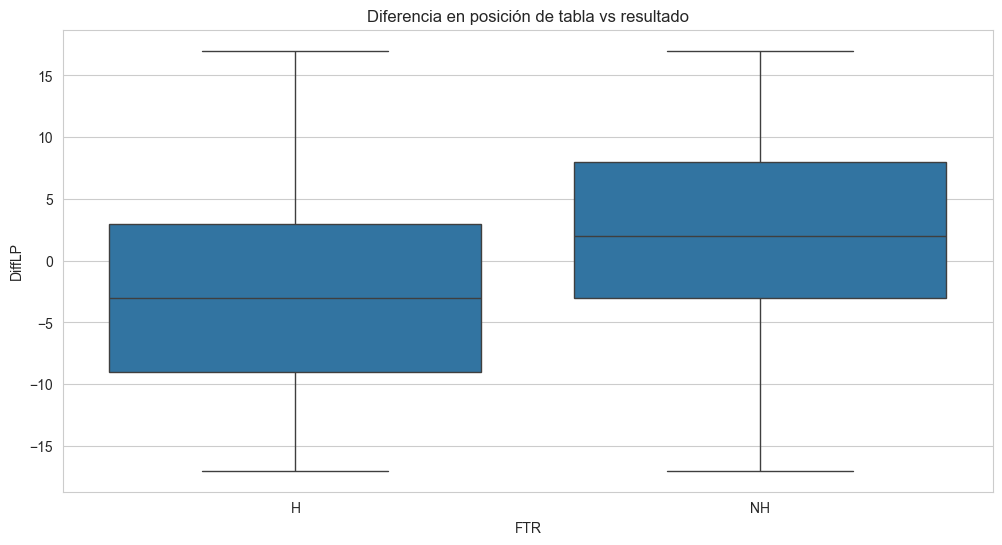

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.boxplot(x='FTR', y='HTP', data=data, ax=axes[0])
axes[0].set_title('Puntos del equipo local según resultado')

sns.boxplot(x='FTR', y='ATP', data=data, ax=axes[1])
axes[1].set_title('Puntos del equipo visitante según resultado')

plt.show()

# Diferencias de puntos y forma
sns.boxplot(x='FTR', y='DiffPts', data=data)
plt.title('Diferencia de puntos vs resultado')
plt.show()

sns.boxplot(x='FTR', y='DiffFormPts', data=data)
plt.title('Diferencia de forma reciente vs resultado')
plt.show()

sns.boxplot(x='FTR', y='DiffLP', data=data)
plt.title('Diferencia en posición de tabla vs resultado')
plt.show()

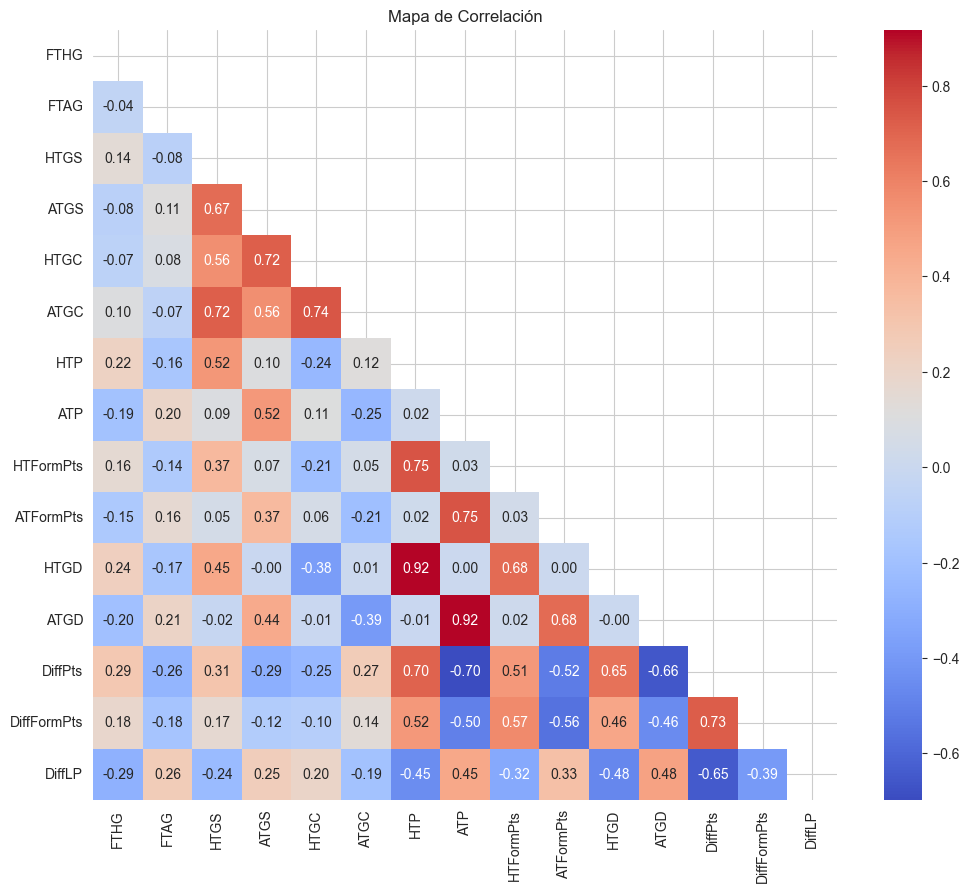

In [25]:
corr = data.corr(numeric_only=True)

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', mask=np.triu(corr))
plt.title('Mapa de Correlación')
plt.show()

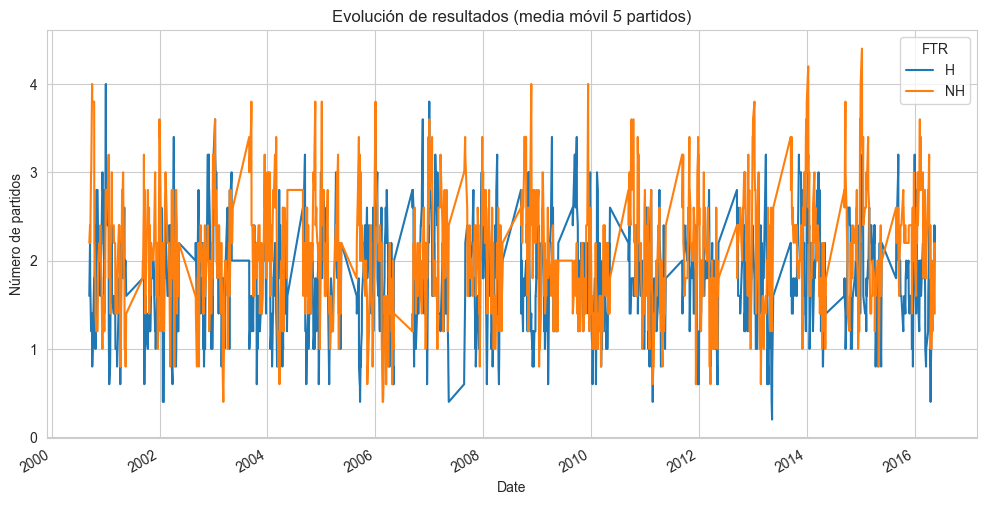

In [31]:
result_by_date = data.groupby('Date')['FTR'].value_counts().unstack().fillna(0)

result_by_date.rolling(5).mean().plot()
plt.title('Evolución de resultados (media móvil 5 partidos)')
plt.ylabel('Número de partidos')
plt.show()

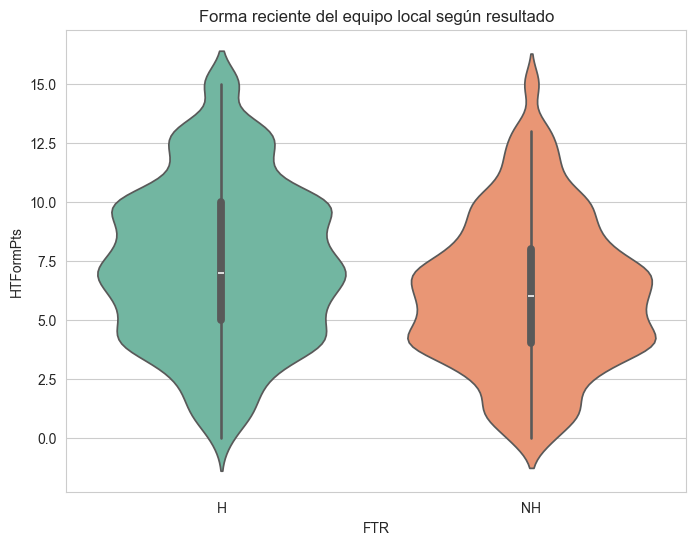

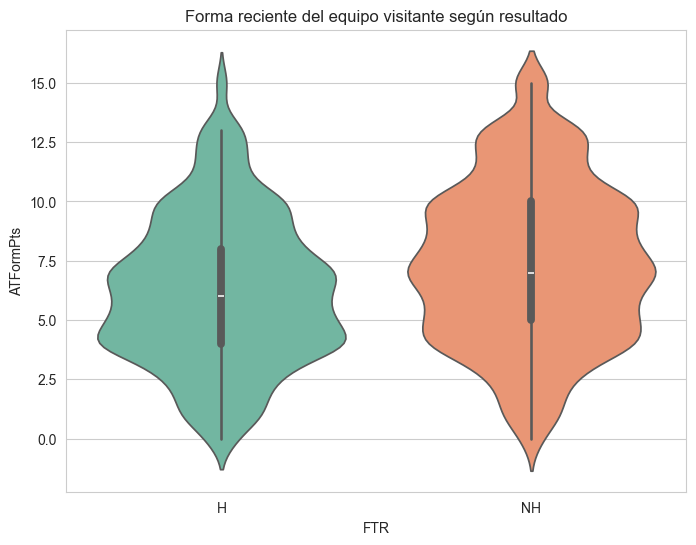

In [32]:
plt.figure(figsize=(8,6))
sns.violinplot(x='FTR', y='HTFormPts', data=data, palette='Set2')
plt.title('Forma reciente del equipo local según resultado')
plt.show()

plt.figure(figsize=(8,6))
sns.violinplot(x='FTR', y='ATFormPts', data=data, palette='Set2')
plt.title('Forma reciente del equipo visitante según resultado')
plt.show()

In [34]:
# Features y target
X = data.drop(['FTR', 'Date', 'HomeTeam', 'AwayTeam'], axis=1, errors='ignore')
y = data['FTR']

# Estandarización de variables numéricas relevantes
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columns_to_scale = ['HTGD', 'ATGD', 'HTP', 'ATP', 'DiffLP', 'DiffFormPts', 'DiffPts']

X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

X.head()

,FTHG,FTAG,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,...,AM1,AM2,AM3,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
30,6,0,5,2,3,1,-0.043829,-0.611968,D,D,...,D,W,L,5,4,0.753719,0.355995,0.404186,0.739161,-1.989216
31,1,1,3,4,5,7,-1.120644,-2.238746,L,L,...,D,L,L,3,1,-0.737082,-1.138834,0.790174,1.444534,-0.248963
32,3,2,4,5,4,4,-0.582236,-0.611968,L,D,...,D,W,L,4,4,0.008318,0.355995,0.018198,0.033788,-0.373267
33,1,1,7,6,8,7,-1.120644,-1.696487,L,L,...,D,L,D,3,2,-0.364382,-0.391419,0.404186,0.739161,0.372556
34,2,2,5,7,5,4,-0.582236,0.472551,D,L,...,W,W,L,4,6,0.008318,1.103409,-0.753777,-1.376958,0.372556
